In [1]:
import os
import re
import json
import string
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, TFAutoModel, AutoTokenizer, BertTokenizer
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

2025-06-03 17:10:22.899627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data loading

In [3]:
df = pd.read_csv('click-id/dataset_with_image/combined_final_final.csv')

In [4]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_score"].values
)

print(f"Total training examples: {len(df_train)}")
print(f"Total validation examples: {len(df_test)}")

Total training examples: 11174
Total validation examples: 2794


### Tokenizer and Model

In [5]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

In [6]:
df_train, df_val = train_test_split(df[['title','content','image_path_processed','label_score']],test_size = 0.2 ,random_state = 93)
df_train.shape , df_val.shape

((11174, 4), (2794, 4))

In [7]:
tokens_train = {
   'title':tokenizer.batch_encode_plus(
    df_train['title'].tolist(),
    max_length = 32,
    padding = 'max_length',
    truncation = True
   ),
    'content':tokenizer.batch_encode_plus(
    df_train['content'].tolist(),
    max_length = 128,
    padding = 'max_length',
    truncation = True
   )
}

tokens_val = {
  'title' : tokenizer.batch_encode_plus(
    df_val['title'].tolist(),
    max_length = 32,
    padding = 'max_length',
    truncation=True
  ),
  'content' : tokenizer.batch_encode_plus(
    df_val['content'].tolist(),
    max_length = 128,
    padding = 'max_length',
    truncation=True
  )
}

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

def load_and_preprocess_images(image_paths):
    images = []
    n = 0
    for path in image_paths:
        n = n+1
        newpath = "/".join(i for i in path.split("/")[-4:])
        
        img = tf.io.read_file(newpath)
        img = tf.image.decode_image(img, channels=3)
        # img = tf.cast(img, tf.float32)
        # img = img/255.0

        images.append(img)
        if n%100 == 0:
          print(n,'images processed')
    return tf.stack(images)

with tf.device("/cpu:0"):
    train_images = load_and_preprocess_images(df_train['image_path_processed'].tolist())
    val_images = load_and_preprocess_images(df_val['image_path_processed'].tolist())

2025-06-03 16:34:32.496536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 16:34:32.496622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 16:34:32.496669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 16:34:32.747567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 16:34:32.747632: I external/local_xla/xla/stream_executor

100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1100 images processed
1200 images processed
1300 images processed
1400 images processed
1500 images processed
1600 images processed
1700 images processed
1800 images processed
1900 images processed
2000 images processed
2100 images processed
2200 images processed
2300 images processed
2400 images processed
2500 images processed
2600 images processed
2700 images processed
2800 images processed
2900 images processed
3000 images processed
3100 images processed
3200 images processed
3300 images processed
3400 images processed
3500 images processed
3600 images processed
3700 images processed
3800 images processed
3900 images processed
4000 images processed
4100 images processed
4200 images processed
4300 images processed
4400 images processed
4500 images processed
4600 images process

2025-06-03 16:34:44.475509: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1681999872 exceeds 10% of free system memory.


100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1100 images processed
1200 images processed
1300 images processed
1400 images processed
1500 images processed
1600 images processed
1700 images processed
1800 images processed
1900 images processed
2000 images processed
2100 images processed
2200 images processed
2300 images processed
2400 images processed
2500 images processed
2600 images processed
2700 images processed


In [16]:
with tf.device("/cpu:0"):
    def save_tf_dataset(images, filename):
        dataset = tf.data.Dataset.from_tensor_slices(images)
        
        tf.data.Dataset.save(dataset, filename)
        print(f"Dataset saved to {filename}")
    
    # Save the datasets
    save_tf_dataset(train_images, "./train_images_dataset")
    save_tf_dataset(val_images, "./val_images_dataset")

2025-06-03 16:34:47.159727: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1681999872 exceeds 10% of free system memory.


Dataset saved to ./train_images_dataset
Dataset saved to ./val_images_dataset


In [8]:
train_images = tf.data.Dataset.load("train_images_dataset")
val_images = tf.data.Dataset.load("val_images_dataset")
train_images

2025-06-03 16:50:12.278872: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 16:50:12.278958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 16:50:12.278996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 16:50:12.489969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 16:50:12.490031: I external/local_xla/xla/stream_executor

<_LoadDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None)>

In [53]:
train_data = {
    'title':tf.squeeze(tf.convert_to_tensor(tokens_train['title']['input_ids'])),
    'content':tf.squeeze(tf.convert_to_tensor(tokens_train['content']['input_ids'])),
    'titlemask':tf.squeeze(tf.convert_to_tensor(tokens_train['title']['attention_mask'])),
    'contentmask':tf.squeeze(tf.convert_to_tensor(tokens_train['content']['attention_mask'])),
}

validation_data = {
    'title':tf.convert_to_tensor(tokens_val['title']['input_ids']),
    'content':tf.convert_to_tensor(tokens_val['content']['input_ids']),
    'titlemask':tf.convert_to_tensor(tokens_val['title']['attention_mask']),
    'contentmask':tf.convert_to_tensor(tokens_val['content']['attention_mask']),
}

label_train = tf.convert_to_tensor(df_train['label_score'].tolist())
label_val = tf.convert_to_tensor(df_val['label_score'].tolist())

In [54]:
dataset = (tf.data.Dataset.from_tensor_slices((dict(train_data),label_train))
    .prefetch(tf.data.AUTOTUNE)
    .cache()
    )
dataVal = (tf.data.Dataset.from_tensor_slices((dict(validation_data),label_val))
    .prefetch(tf.data.AUTOTUNE)
    .cache()
    )

dataset = tf.data.Dataset.zip((dataset, train_images))
dataVal = tf.data.Dataset.zip((dataVal, val_images))

def add_image_and_fix_shapes(text_data_label, image):
    text_data, label = text_data_label
    new_data = {
        'title': tf.ensure_shape(text_data['title'], [None, 32]),
        'content': tf.ensure_shape(text_data['content'], [None, 128]),
        'titlemask': tf.ensure_shape(text_data['titlemask'], [None, 32]),
        'contentmask': tf.ensure_shape(text_data['contentmask'], [None, 128]),
        'image': image
    }
    
    return new_data, label

dataset = (dataset
    .batch(32)
    .map(add_image_and_fix_shapes)
    .prefetch(tf.data.AUTOTUNE)
    .cache()
)

dataVal = (dataVal
    .batch(32)
    .map(add_image_and_fix_shapes)
    .prefetch(tf.data.AUTOTUNE)
    .cache()
)
dataset

<CacheDataset element_spec=({'title': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'content': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'titlemask': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'contentmask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
tf.data.Dataset.save(dataset, "./dataset")
tf.data.Dataset.save(dataVal, "./dataVal")

In [2]:
dataset = tf.data.Dataset.load(
    "dataset",
    element_spec=({
        'title': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'content': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'titlemask': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'contentmask': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8)
    }, tf.TensorSpec(shape=(None,), dtype=tf.int32))
)

dataVal = tf.data.Dataset.load(
    "dataVal",
    element_spec=({
        'title': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'content': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'titlemask': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'contentmask': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8)
    }, tf.TensorSpec(shape=(None,), dtype=tf.int32))
)
dataset

2025-06-03 17:10:29.101708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 17:10:29.186675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 17:10:29.186736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 17:10:29.189208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 17:10:29.189259: I external/local_xla/xla/stream_executor

<_LoadDataset element_spec=({'title': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'content': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'titlemask': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'contentmask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

[CLS] peringatkan farhat abbas, hotman paris : jaga kesehatan dan minum vitamin [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


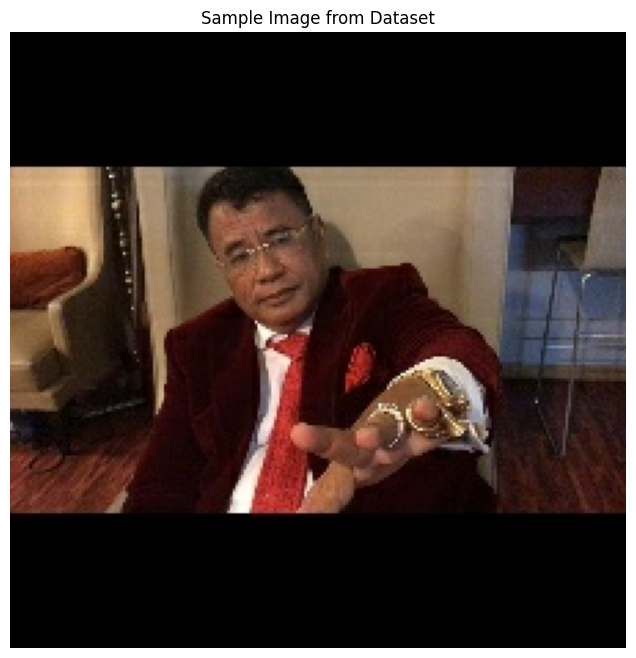

2025-06-03 17:08:23.748033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import matplotlib.pyplot as plt

for batch in dataset.take(1):
    features, _ = batch
    title_text = tokenizer.decode(features['title'][0].numpy())
    content_text = tokenizer.decode(features['content'][0].numpy())
    print(title_text)
    image = features['image'][0].numpy()  
    
    if image.max() > 1.0:
        image = image / 255.0
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Sample Image from Dataset')
    plt.show()

In [ ]:
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super(BertEmbeddingLayer, self).__init__(**kwargs)
        self.model_name = model_name
        self.embedding_size = None
        self.bert = None

    def build(self, input_shape):
        self.bert = TFAutoModel.from_pretrained(self.model_name)
        self.embedding_size = self.bert.config.hidden_size
        super(BertEmbeddingLayer, self).build(input_shape)

    def call(self, inputs):
        ids, att = inputs
        outputs = self.bert(input_ids=ids, attention_mask=att)
        return outputs.pooler_output

    def get_config(self):
        config = super(BertEmbeddingLayer, self).get_config()
        config.update({"model_name": self.model_name})
        return config

In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")
    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    title = indobert1([ids1, att1])
    content = indobert2([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

final = makemodel()
final.summary()

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/encoder/layer_._11/output/LayerNorm/beta:0', 'bert/embeddings/LayerNorm/gamma:0', 'bert/encoder/layer_._11/intermediate/dense/kernel:0', 'bert/encoder/layer_._8/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._11/output/LayerNorm/gamma:0', 'bert/encoder/layer_._8/attention/self/value/bias:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert/encoder/layer_._6/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._3/output/dense/kernel:0', 'bert/encoder/layer_._2/attention/self/key/kernel:0', 'bert/encoder/layer_._0/attention/output/dense/bias:0', 'bert/encoder/layer_._1/attention/self/query/kernel:0', 'bert/encoder/layer_._4/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/output/dense/kernel:0', 'bert/encoder/layer_._3/output/dense/bias:0', 'bert/encoder/layer_._6/attention/output/dense/bias:0', 'bert/encoder/la

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ image[0][0]       │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation  │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ random_translati… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title (InputLayer)  │ (None, 32)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ titlemask           │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ content             │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contentmask         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indobert1           │ (None, 768)       │          0 │ title[0][0],      │
│ (BertEmbeddingLaye… │                   │            │ titlemask[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indobert2           │ (None, 768)       │          0 │ content[0][0],    │
│ (BertEmbeddingLaye… │                   │            │ contentmask[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 1280)      │  5,919,312 │ random_contrast[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2816)      │          0 │ indobert1[0][0],  │
│ (Concatenate)       │                   │            │ indobert2[0][0],  │
│                     │                   │            │ efficientnetv2-b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2816)      │     11,264 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,442,304 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 7,549,009 (28.80 MB)

 Trainable params: 7,480,977 (28.54 MB)

 Non-trainable params: 68,032 (265.75 KB)

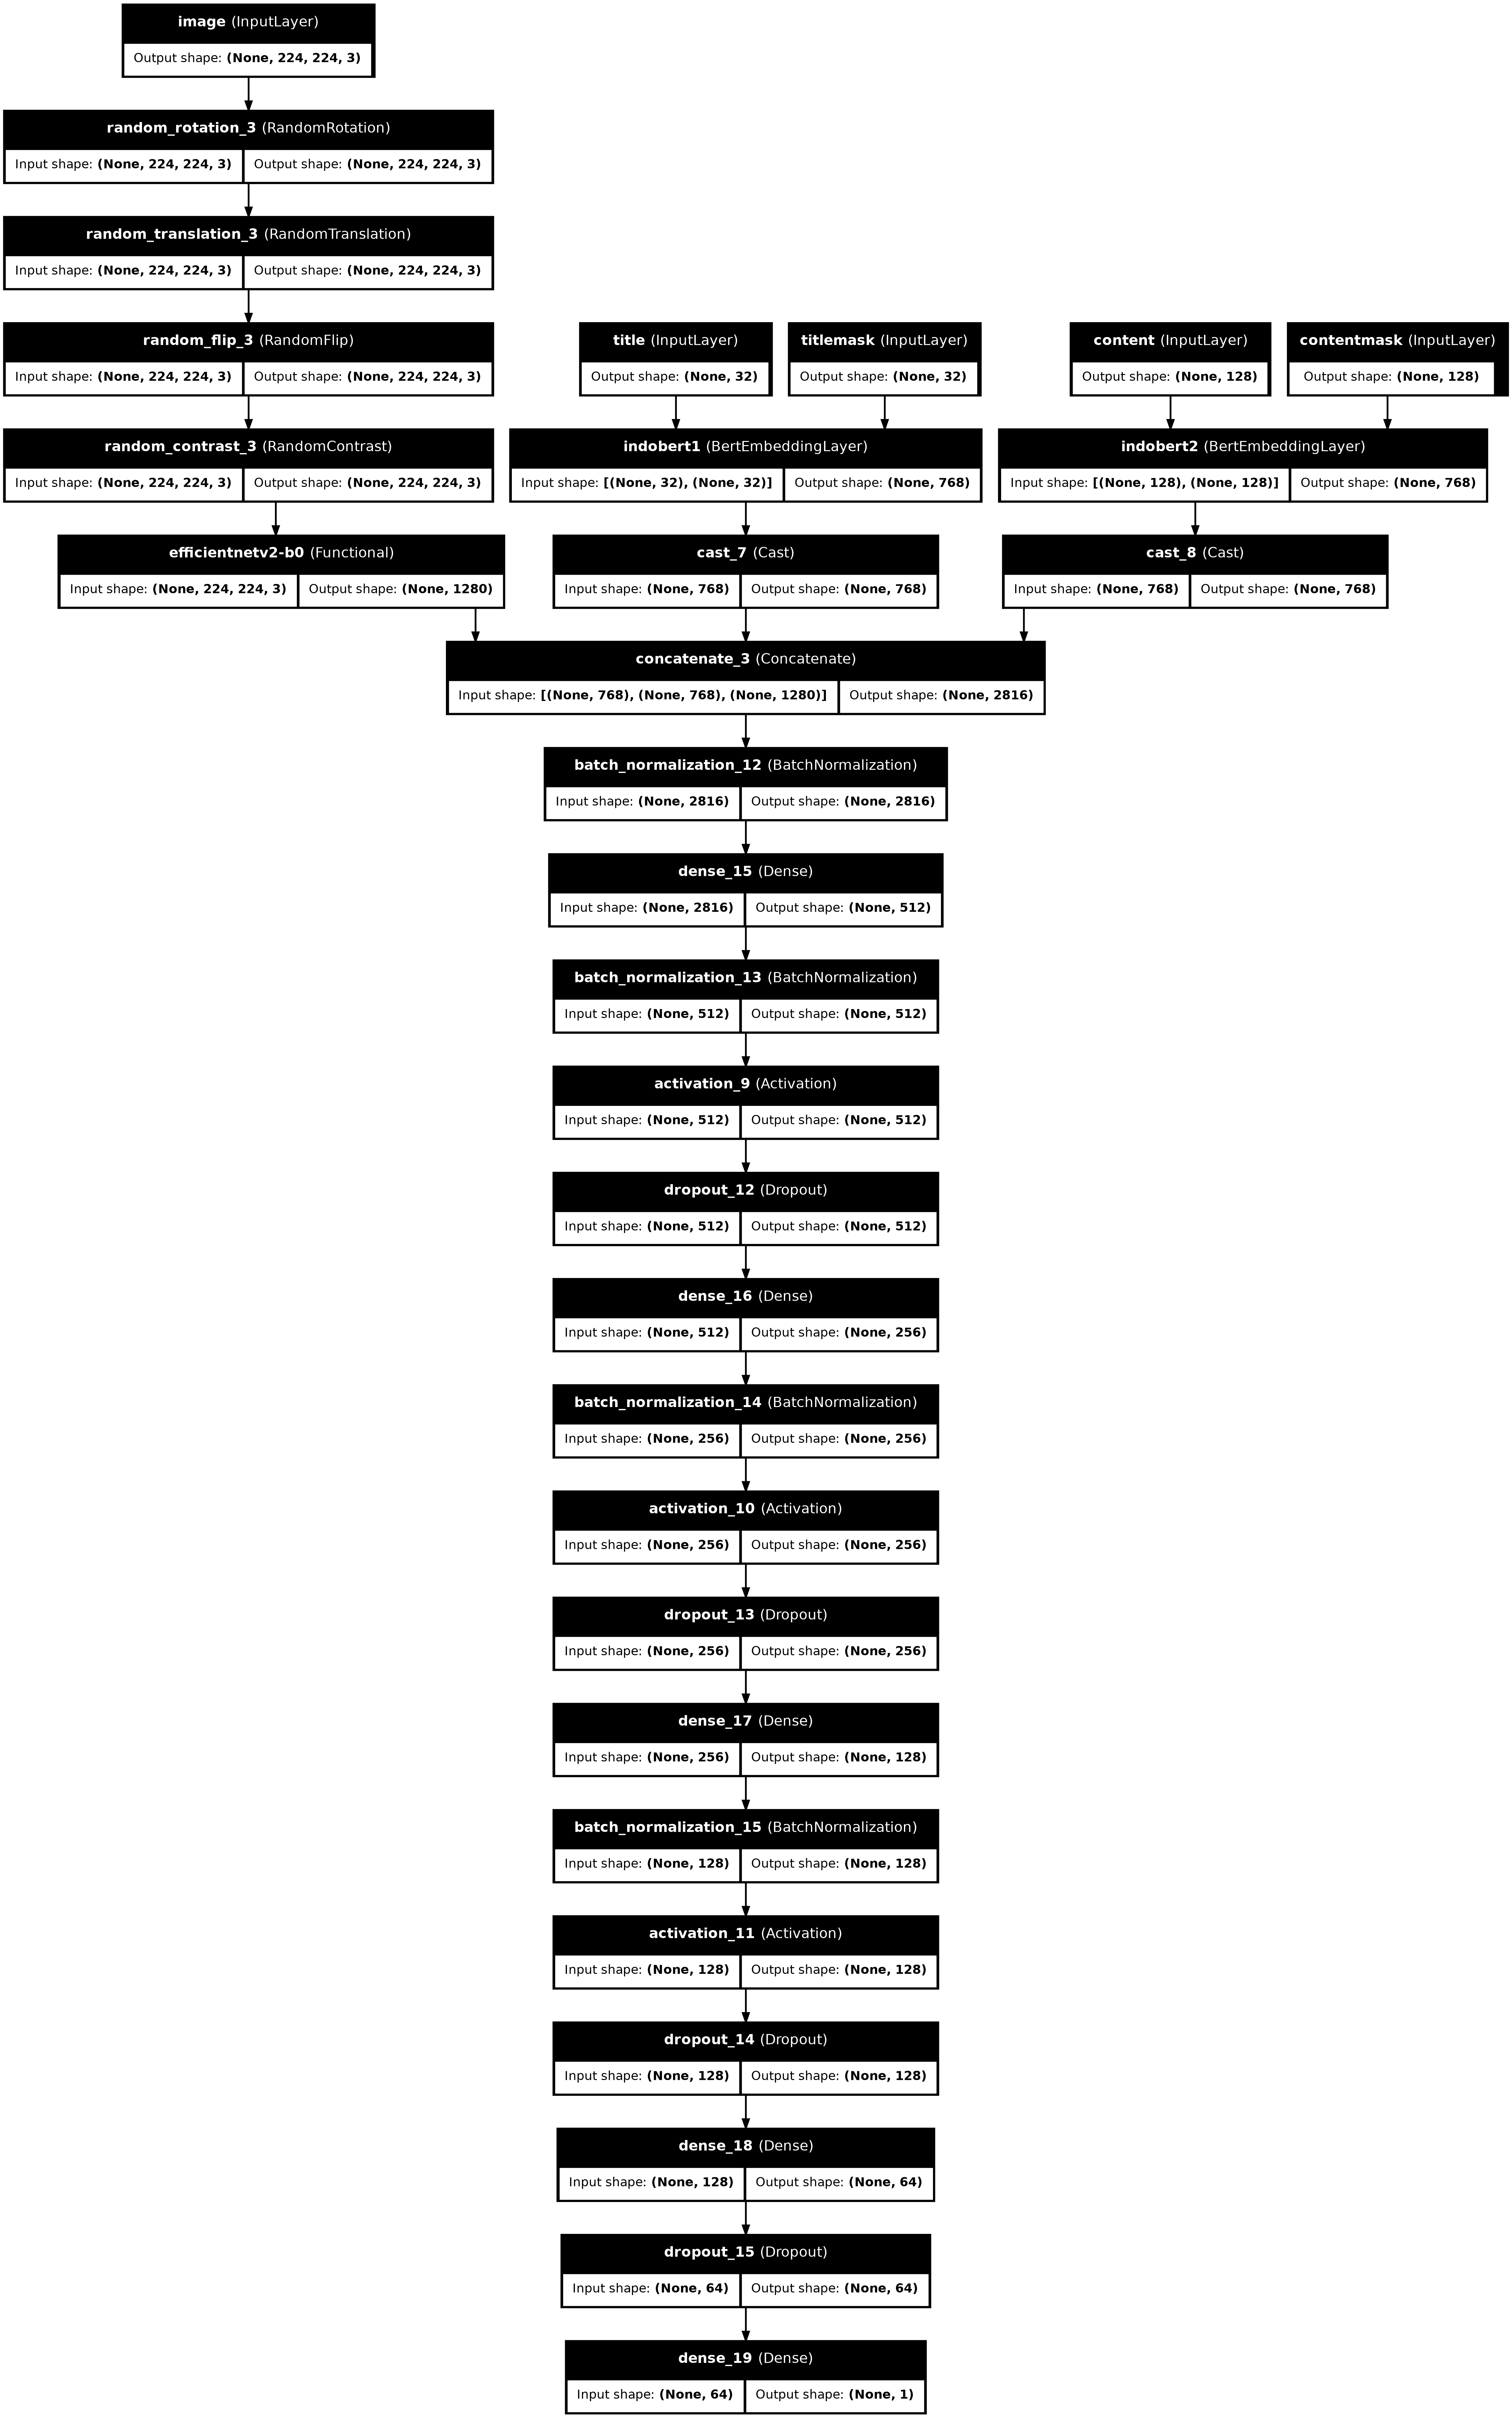

In [62]:
from tensorflow.keras.utils import plot_model
plot_model(
    final,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False
    )

In [5]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/best_model_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=final.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

Epoch 1/50


2025-06-03 17:11:41.009659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-06-03 17:11:46.462036: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


350/350 ━━━━━━━━━━━━━━━━━━━━ 259s 591ms/step - binary_accuracy: 0.5296 - loss: 0.7717 - precision: 0.4600 - recall: 0.4751 - val_binary_accuracy: 0.6281 - val_loss: 0.6516 - val_precision: 0.5921 - val_recall: 0.4054 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 200s 570ms/step - binary_accuracy: 0.5968 - loss: 0.6935 - precision: 0.5414 - recall: 0.4523 - val_binary_accuracy: 0.6757 - val_loss: 0.6004 - val_precision: 0.6365 - val_recall: 0.5551 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 200s 571ms/step - binary_accuracy: 0.6329 - loss: 0.6552 - precision: 0.5879 - recall: 0.5133 - val_binary_accuracy: 0.6915 - val_loss: 0.5817 - val_precision: 0.6482 - val_recall: 0.6013 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 200s 571ms/step - binary_accuracy: 0.6525 - loss: 0.6278 - precision: 0.6152 - recall: 0.5295 - val_binary_accuracy: 0.6972 - val_loss: 0.5694 - val_precision: 0.6506 - val_recall: 0.6232 - learning_rate

dict_keys(['binary_accuracy', 'loss', 'precision', 'recall', 'val_binary_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])
Final training loss: 0.4905705451965332


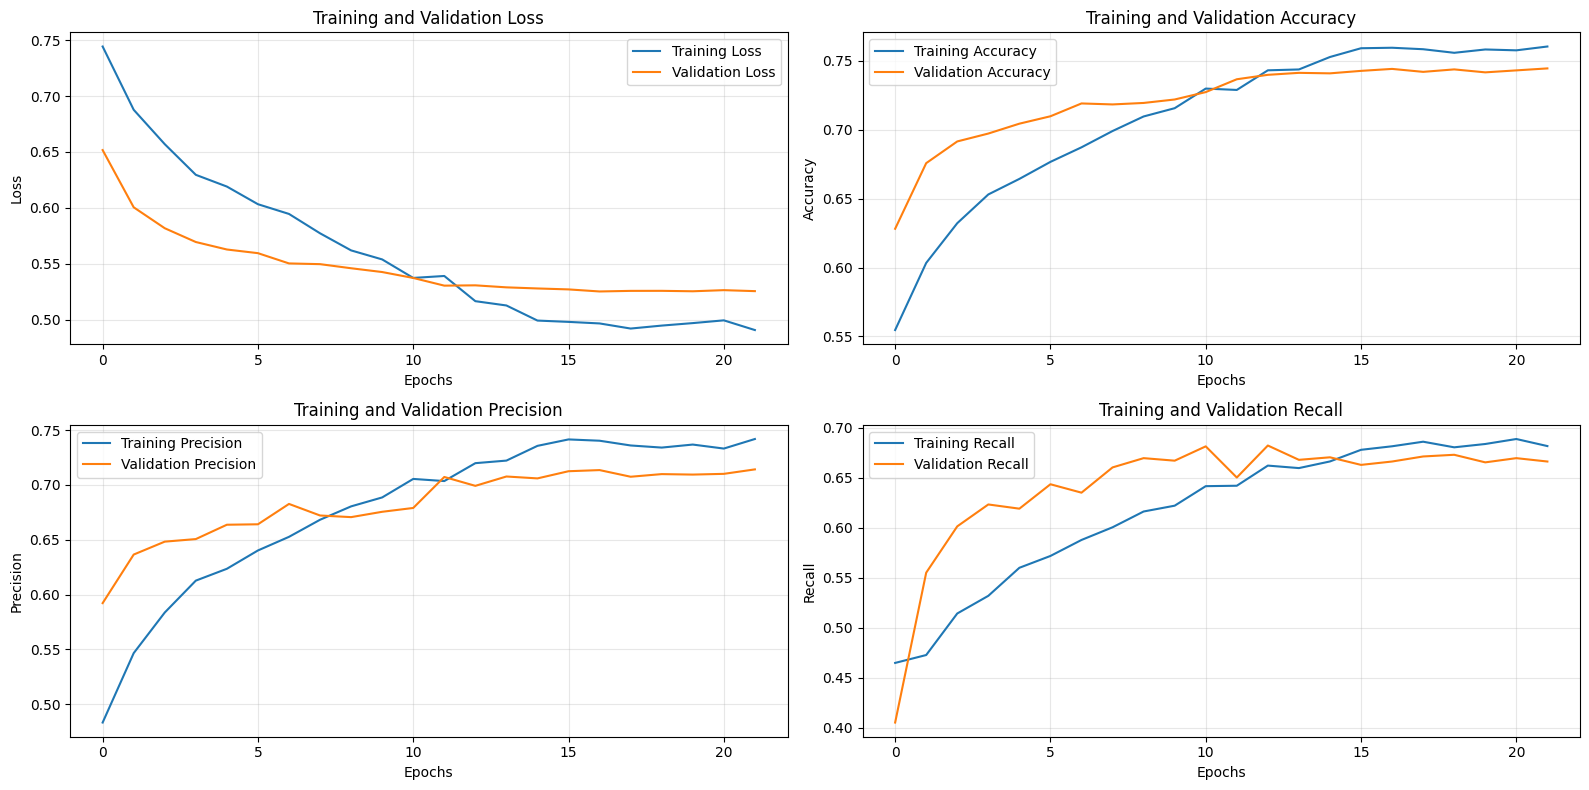


FINAL METRICS SUMMARY
Loss           : Train = 0.4906, Val = 0.5254
Binary_accuracy: Train = 0.7603, Val = 0.7445
Precision      : Train = 0.7419, Val = 0.7142
Recall         : Train = 0.6815, Val = 0.6661


In [6]:
print(history.history.keys())
final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()